In [1]:
from bacp import BaCPTrainer, BaCPTrainingArguments
from trainer import Trainer, TrainingArguments
from utils import print_statistics, get_device, get_num_workers, print_dynamic_lambdas_statistics, load_object, save_object
from constants import *

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME = 'resnet50'
MODEL_TASK = 'cifar10'
FINETUNED_WEIGHTS = './research/resnet50/cifar10/resnet50_cifar10_baseline.pt'
TRAIN = False
DEVICE = get_device()
NUM_WORKERS = get_num_workers()
print("Using device:", DEVICE)
print("Using", NUM_WORKERS, "workers")

Using device: cuda
Using 288 workers


## Baseline Check

In [3]:
training_args = TrainingArguments(
    model_name=MODEL_NAME,
    model_task=MODEL_TASK,
    batch_size=BATCH_SIZE_CNN,
    optimizer_type_and_lr=('sgd', 0.01),
    scheduler_type='linear_with_warmup',
    epochs=100,
    learning_type="baseline",
    patience=50,
    db=False,
)
trainer = Trainer(training_args=training_args)
metrics = trainer.evaluate()
print_statistics(metrics, trainer)

[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.01)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] Linear scheduler initialized with warmup steps: 830 and total steps: 8300
[TRAINER] Pruning not initialized
[TRAINER] Saving model to: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.0



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.02%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        baseline
  Batch Size:           512
  Learning Rate:        0.01
  Optimizer:            sgd
  Epochs:               100

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24



## BaCP

[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[TRAINER] No scheduler initialized
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] Pruning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Target sparsity: 0.95
[TRAINER] Sparsity scheduler: cubic
[TRAINER] Pruning epochs: 5
[TRAINER] Current sparsity: 0.0000
[TRAINER] Saving model to: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b1.pt
[LOGGER] Log file created at location: ./log_records/resnet50/cifar10/bacp_pruning_b1/magnitude_pruning/0.95/run_2.log


Training Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.464.



Epoch [1/5]: Avg Total Loss: 7.1401 | Avg PrC Loss: 3.3686 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3830 | Avg CE Loss: 0.3885 | Model Sparsity: 0.4636

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 5.5881 | Avg PrC Loss: 2.8186 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.5585 | Avg CE Loss: 0.2110 | Model Sparsity: 0.4636



Retraining Epoch [2/10]: Avg Total Loss: 4.6158 | Avg PrC Loss: 2.3668 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.0831 | Avg CE Loss: 0.1659 | Model Sparsity: 0.4636



Retraining Epoch [3/10]: Avg Total Loss: 3.9224 | Avg PrC Loss: 1.9987 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.7821 | Avg CE Loss: 0.1416 | Model Sparsity: 0.4636



Retraining Epoch [4/10]: Avg Total Loss: 3.3524 | Avg PrC Loss: 1.6971 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.5277 | Avg CE Loss: 0.1276 | Model Sparsity: 0.4636



Retraining Epoch [5/10]: Avg Total Loss: 2.8944 | Avg PrC Loss: 1.4556 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.3221 | Avg CE Loss: 0.1167 | Model Sparsity: 0.4636



Retraining Epoch [6/10]: Avg Total Loss: 2.5315 | Avg PrC Loss: 1.2618 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.1560 | Avg CE Loss: 0.1136 | Model Sparsity: 0.4636



Retraining Epoch [7/10]: Avg Total Loss: 2.2312 | Avg PrC Loss: 1.1054 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.0196 | Avg CE Loss: 0.1062 | Model Sparsity: 0.4636



Retraining Epoch [8/10]: Avg Total Loss: 1.9885 | Avg PrC Loss: 0.9776 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 0.9079 | Avg CE Loss: 0.1030 | Model Sparsity: 0.4636



Retraining Epoch [9/10]: Avg Total Loss: 1.7895 | Avg PrC Loss: 0.8729 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 0.8148 | Avg CE Loss: 0.1018 | Model Sparsity: 0.4636



Retraining Epoch [10/10]: Avg Total Loss: 1.6255 | Avg PrC Loss: 0.7859 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 0.7378 | Avg CE Loss: 0.1018 | Model Sparsity: 0.4636



Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:20,  1.02it/s, Loss=6.71, PrC Loss=0.745, SnC Loss=5.16, FiC Loss=0.703, CE Loss=0.0995]


[Pruner] Cubic Sparsity ratio increased to 0.745.



Epoch [2/5]: Avg Total Loss: 6.5484 | Avg PrC Loss: 0.7487 | Avg SnC Loss: 4.9450 | Avg FiC Loss: 0.7017 | Avg CE Loss: 0.1531 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 5.5671 | Avg PrC Loss: 0.6989 | Avg SnC Loss: 4.0441 | Avg FiC Loss: 0.6543 | Avg CE Loss: 0.1697 | Model Sparsity: 0.7448



Retraining Epoch [2/10]: Avg Total Loss: 4.6726 | Avg PrC Loss: 0.6344 | Avg SnC Loss: 3.2559 | Avg FiC Loss: 0.5969 | Avg CE Loss: 0.1855 | Model Sparsity: 0.7448



Retraining Epoch [3/10]: Avg Total Loss: 3.8754 | Avg PrC Loss: 0.5619 | Avg SnC Loss: 2.5850 | Avg FiC Loss: 0.5306 | Avg CE Loss: 0.1979 | Model Sparsity: 0.7448



Retraining Epoch [4/10]: Avg Total Loss: 3.2389 | Avg PrC Loss: 0.4920 | Avg SnC Loss: 2.0609 | Avg FiC Loss: 0.4672 | Avg CE Loss: 0.2187 | Model Sparsity: 0.7448



Retraining Epoch [5/10]: Avg Total Loss: 2.7442 | Avg PrC Loss: 0.4298 | Avg SnC Loss: 1.6669 | Avg FiC Loss: 0.4103 | Avg CE Loss: 0.2373 | Model Sparsity: 0.7448



Retraining Epoch [6/10]: Avg Total Loss: 2.3298 | Avg PrC Loss: 0.3775 | Avg SnC Loss: 1.3622 | Avg FiC Loss: 0.3603 | Avg CE Loss: 0.2297 | Model Sparsity: 0.7448



Retraining Epoch [7/10]: Avg Total Loss: 2.0329 | Avg PrC Loss: 0.3340 | Avg SnC Loss: 1.1395 | Avg FiC Loss: 0.3198 | Avg CE Loss: 0.2396 | Model Sparsity: 0.7448



Retraining Epoch [8/10]: Avg Total Loss: 1.7964 | Avg PrC Loss: 0.2984 | Avg SnC Loss: 0.9690 | Avg FiC Loss: 0.2862 | Avg CE Loss: 0.2429 | Model Sparsity: 0.7448



Retraining Epoch [9/10]: Avg Total Loss: 1.6117 | Avg PrC Loss: 0.2687 | Avg SnC Loss: 0.8372 | Avg FiC Loss: 0.2583 | Avg CE Loss: 0.2475 | Model Sparsity: 0.7448



Retraining Epoch [10/10]: Avg Total Loss: 1.4518 | Avg PrC Loss: 0.2441 | Avg SnC Loss: 0.7317 | Avg FiC Loss: 0.2347 | Avg CE Loss: 0.2414 | Model Sparsity: 0.7448



Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:25,  1.04s/it, Loss=2.11, PrC Loss=0.233, SnC Loss=1.36, FiC Loss=0.226, CE Loss=0.283]


[Pruner] Cubic Sparsity ratio increased to 0.889.



Epoch [3/5]: Avg Total Loss: 1.9062 | Avg PrC Loss: 0.2219 | Avg SnC Loss: 1.2323 | Avg FiC Loss: 0.2120 | Avg CE Loss: 0.2401 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 1.6400 | Avg PrC Loss: 0.1975 | Avg SnC Loss: 1.0221 | Avg FiC Loss: 0.1887 | Avg CE Loss: 0.2317 | Model Sparsity: 0.8892



Retraining Epoch [2/10]: Avg Total Loss: 1.4481 | Avg PrC Loss: 0.1781 | Avg SnC Loss: 0.8686 | Avg FiC Loss: 0.1705 | Avg CE Loss: 0.2309 | Model Sparsity: 0.8892



Retraining Epoch [3/10]: Avg Total Loss: 1.3059 | Avg PrC Loss: 0.1624 | Avg SnC Loss: 0.7533 | Avg FiC Loss: 0.1556 | Avg CE Loss: 0.2346 | Model Sparsity: 0.8892



Retraining Epoch [4/10]: Avg Total Loss: 1.1926 | Avg PrC Loss: 0.1492 | Avg SnC Loss: 0.6630 | Avg FiC Loss: 0.1432 | Avg CE Loss: 0.2371 | Model Sparsity: 0.8892



Retraining Epoch [5/10]: Avg Total Loss: 1.0958 | Avg PrC Loss: 0.1382 | Avg SnC Loss: 0.5912 | Avg FiC Loss: 0.1327 | Avg CE Loss: 0.2336 | Model Sparsity: 0.8892



Retraining Epoch [6/10]: Avg Total Loss: 1.0162 | Avg PrC Loss: 0.1288 | Avg SnC Loss: 0.5325 | Avg FiC Loss: 0.1238 | Avg CE Loss: 0.2312 | Model Sparsity: 0.8892



Retraining Epoch [7/10]: Avg Total Loss: 0.9629 | Avg PrC Loss: 0.1206 | Avg SnC Loss: 0.4842 | Avg FiC Loss: 0.1161 | Avg CE Loss: 0.2419 | Model Sparsity: 0.8892



Retraining Epoch [8/10]: Avg Total Loss: 0.8980 | Avg PrC Loss: 0.1135 | Avg SnC Loss: 0.4428 | Avg FiC Loss: 0.1092 | Avg CE Loss: 0.2324 | Model Sparsity: 0.8892



Retraining Epoch [9/10]: Avg Total Loss: 0.8583 | Avg PrC Loss: 0.1073 | Avg SnC Loss: 0.4087 | Avg FiC Loss: 0.1034 | Avg CE Loss: 0.2390 | Model Sparsity: 0.8892



Retraining Epoch [10/10]: Avg Total Loss: 0.8227 | Avg PrC Loss: 0.1017 | Avg SnC Loss: 0.3784 | Avg FiC Loss: 0.0980 | Avg CE Loss: 0.2447 | Model Sparsity: 0.8892



Training Epoch [4/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.942.



Epoch [4/5]: Avg Total Loss: 0.9477 | Avg PrC Loss: 0.0970 | Avg SnC Loss: 0.5160 | Avg FiC Loss: 0.0930 | Avg CE Loss: 0.2418 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 0.8782 | Avg PrC Loss: 0.0913 | Avg SnC Loss: 0.4706 | Avg FiC Loss: 0.0877 | Avg CE Loss: 0.2286 | Model Sparsity: 0.9424



Retraining Epoch [2/10]: Avg Total Loss: 0.8315 | Avg PrC Loss: 0.0865 | Avg SnC Loss: 0.4322 | Avg FiC Loss: 0.0829 | Avg CE Loss: 0.2299 | Model Sparsity: 0.9424



Retraining Epoch [3/10]: Avg Total Loss: 0.7974 | Avg PrC Loss: 0.0821 | Avg SnC Loss: 0.4003 | Avg FiC Loss: 0.0789 | Avg CE Loss: 0.2361 | Model Sparsity: 0.9424



Retraining Epoch [4/10]: Avg Total Loss: 0.7570 | Avg PrC Loss: 0.0782 | Avg SnC Loss: 0.3716 | Avg FiC Loss: 0.0752 | Avg CE Loss: 0.2320 | Model Sparsity: 0.9424



Retraining Epoch [5/10]: Avg Total Loss: 0.7289 | Avg PrC Loss: 0.0747 | Avg SnC Loss: 0.3469 | Avg FiC Loss: 0.0718 | Avg CE Loss: 0.2355 | Model Sparsity: 0.9424



Retraining Epoch [6/10]: Avg Total Loss: 0.6990 | Avg PrC Loss: 0.0715 | Avg SnC Loss: 0.3256 | Avg FiC Loss: 0.0689 | Avg CE Loss: 0.2330 | Model Sparsity: 0.9424



Retraining Epoch [7/10]: Avg Total Loss: 0.6745 | Avg PrC Loss: 0.0687 | Avg SnC Loss: 0.3058 | Avg FiC Loss: 0.0661 | Avg CE Loss: 0.2339 | Model Sparsity: 0.9424



Retraining Epoch [8/10]: Avg Total Loss: 0.6490 | Avg PrC Loss: 0.0660 | Avg SnC Loss: 0.2889 | Avg FiC Loss: 0.0636 | Avg CE Loss: 0.2305 | Model Sparsity: 0.9424



Retraining Epoch [9/10]: Avg Total Loss: 0.6356 | Avg PrC Loss: 0.0636 | Avg SnC Loss: 0.2732 | Avg FiC Loss: 0.0613 | Avg CE Loss: 0.2375 | Model Sparsity: 0.9424



Retraining Epoch [10/10]: Avg Total Loss: 0.6207 | Avg PrC Loss: 0.0614 | Avg SnC Loss: 0.2598 | Avg FiC Loss: 0.0592 | Avg CE Loss: 0.2404 | Model Sparsity: 0.9424



Training Epoch [5/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.950.



Epoch [5/5]: Avg Total Loss: 0.6752 | Avg PrC Loss: 0.0595 | Avg SnC Loss: 0.3250 | Avg FiC Loss: 0.0572 | Avg CE Loss: 0.2335 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 0.6462 | Avg PrC Loss: 0.0572 | Avg SnC Loss: 0.3064 | Avg FiC Loss: 0.0550 | Avg CE Loss: 0.2275 | Model Sparsity: 0.95



Retraining Epoch [2/10]: Avg Total Loss: 0.6232 | Avg PrC Loss: 0.0552 | Avg SnC Loss: 0.2892 | Avg FiC Loss: 0.0530 | Avg CE Loss: 0.2258 | Model Sparsity: 0.95



Retraining Epoch [3/10]: Avg Total Loss: 0.6112 | Avg PrC Loss: 0.0533 | Avg SnC Loss: 0.2746 | Avg FiC Loss: 0.0512 | Avg CE Loss: 0.2322 | Model Sparsity: 0.95



Retraining Epoch [4/10]: Avg Total Loss: 0.5915 | Avg PrC Loss: 0.0515 | Avg SnC Loss: 0.2608 | Avg FiC Loss: 0.0495 | Avg CE Loss: 0.2297 | Model Sparsity: 0.95



Retraining Epoch [5/10]: Avg Total Loss: 0.5821 | Avg PrC Loss: 0.0499 | Avg SnC Loss: 0.2486 | Avg FiC Loss: 0.0480 | Avg CE Loss: 0.2357 | Model Sparsity: 0.95



Retraining Epoch [6/10]: Avg Total Loss: 0.5711 | Avg PrC Loss: 0.0483 | Avg SnC Loss: 0.2372 | Avg FiC Loss: 0.0466 | Avg CE Loss: 0.2390 | Model Sparsity: 0.95



Retraining Epoch [7/10]: Avg Total Loss: 0.5539 | Avg PrC Loss: 0.0469 | Avg SnC Loss: 0.2267 | Avg FiC Loss: 0.0452 | Avg CE Loss: 0.2351 | Model Sparsity: 0.95



Retraining Epoch [8/10]: Avg Total Loss: 0.5393 | Avg PrC Loss: 0.0456 | Avg SnC Loss: 0.2173 | Avg FiC Loss: 0.0439 | Avg CE Loss: 0.2325 | Model Sparsity: 0.95



Retraining Epoch [9/10]: Avg Total Loss: 0.5367 | Avg PrC Loss: 0.0444 | Avg SnC Loss: 0.2086 | Avg FiC Loss: 0.0428 | Avg CE Loss: 0.2409 | Model Sparsity: 0.95



/home/ubuntu/BaCP-1/project/utils.py:110: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.       
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  values = torch.tensor(lambda_history[key]).detach().cpu().numpy()


Retraining Epoch [10/10]: Avg Total Loss: 0.5152 | Avg PrC Loss: 0.0432 | Avg SnC Loss: 0.2002 | Avg FiC Loss: 0.0416 | Avg CE Loss: 0.2302 | Model Sparsity: 0.95



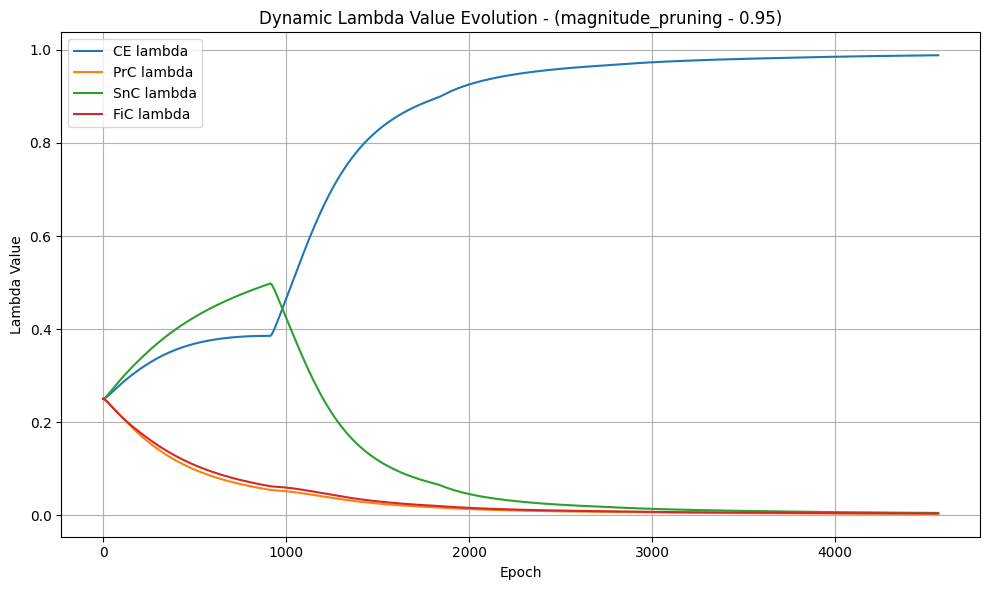

=== Lambda Statistics ===
CE lambda:
  Initial: 0.2500
  Final:   0.9884
  Change:  0.7384 (+295.37%)
  Mean:    0.7949
  StdDev:  0.2541

PrC lambda:
  Initial: 0.2500
  Final:   0.0030
  Change:  -0.2470 (-98.79%)
  Mean:    0.0350
  StdDev:  0.0521

SnC lambda:
  Initial: 0.2500
  Final:   0.0049
  Change:  -0.2451 (-98.03%)
  Mean:    0.1317
  StdDev:  0.1669

FiC lambda:
  Initial: 0.2500
  Final:   0.0036
  Change:  -0.2464 (-98.54%)
  Mean:    0.0384
  StdDev:  0.0535

[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b1.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b1.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation

Training epoch [1/50]: Avg Loss: 0.9023 | Avg Accuracy: 91.84 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.2706 | Avg Accuracy: 92.79 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2124 | Avg Accuracy: 93.12 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.1824 | Avg Accuracy: 93.68 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.1697 | Avg Accuracy: 94.10 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.1579 | Avg Accuracy: 93.74 | Model Sparsity: 0.95



Training epoch [7/50]: Avg Loss: 0.1462 | Avg Accuracy: 93.89 | Model Sparsity: 0.95



Training epoch [8/50]: Avg Loss: 0.1399 | Avg Accuracy: 94.20 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.1315 | Avg Accuracy: 94.22 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [10/50]: Avg Loss: 0.1197 | Avg Accuracy: 94.21 | Model Sparsity: 0.95



Training epoch [11/50]: Avg Loss: 0.1177 | Avg Accuracy: 94.31 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [12/50]: Avg Loss: 0.1085 | Avg Accuracy: 94.55 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [13/50]: Avg Loss: 0.1031 | Avg Accuracy: 94.48 | Model Sparsity: 0.95



Training epoch [14/50]: Avg Loss: 0.1003 | Avg Accuracy: 94.56 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [15/50]: Avg Loss: 0.0926 | Avg Accuracy: 94.34 | Model Sparsity: 0.95



Training epoch [16/50]: Avg Loss: 0.0878 | Avg Accuracy: 94.70 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [17/50]: Avg Loss: 0.0893 | Avg Accuracy: 94.84 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [18/50]: Avg Loss: 0.0831 | Avg Accuracy: 94.74 | Model Sparsity: 0.95



Training epoch [19/50]: Avg Loss: 0.0791 | Avg Accuracy: 94.71 | Model Sparsity: 0.95



Training epoch [20/50]: Avg Loss: 0.0724 | Avg Accuracy: 95.01 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [21/50]: Avg Loss: 0.0698 | Avg Accuracy: 94.91 | Model Sparsity: 0.95



Training epoch [22/50]: Avg Loss: 0.0680 | Avg Accuracy: 94.63 | Model Sparsity: 0.95



Training epoch [23/50]: Avg Loss: 0.0632 | Avg Accuracy: 94.61 | Model Sparsity: 0.95



Training epoch [24/50]: Avg Loss: 0.0622 | Avg Accuracy: 94.74 | Model Sparsity: 0.95



Training epoch [25/50]: Avg Loss: 0.0603 | Avg Accuracy: 94.49 | Model Sparsity: 0.95



Training epoch [26/50]: Avg Loss: 0.0548 | Avg Accuracy: 94.75 | Model Sparsity: 0.95



Training epoch [27/50]: Avg Loss: 0.0526 | Avg Accuracy: 94.80 | Model Sparsity: 0.95



Training epoch [28/50]: Avg Loss: 0.0552 | Avg Accuracy: 94.88 | Model Sparsity: 0.95



Training epoch [29/50]: Avg Loss: 0.0501 | Avg Accuracy: 94.63 | Model Sparsity: 0.95



Training epoch [30/50]: Avg Loss: 0.0488 | Avg Accuracy: 94.98 | Model Sparsity: 0.95



Training epoch [31/50]: Avg Loss: 0.0496 | Avg Accuracy: 94.36 | Model Sparsity: 0.95



Training epoch [32/50]: Avg Loss: 0.0450 | Avg Accuracy: 94.92 | Model Sparsity: 0.95



Training epoch [33/50]: Avg Loss: 0.0422 | Avg Accuracy: 94.20 | Model Sparsity: 0.95



Training epoch [34/50]: Avg Loss: 0.0391 | Avg Accuracy: 94.61 | Model Sparsity: 0.95



Training epoch [35/50]: Avg Loss: 0.0421 | Avg Accuracy: 94.43 | Model Sparsity: 0.95



Training epoch [36/50]: Avg Loss: 0.0391 | Avg Accuracy: 94.64 | Model Sparsity: 0.95



Training epoch [37/50]: Avg Loss: 0.0352 | Avg Accuracy: 94.87 | Model Sparsity: 0.95



Training epoch [38/50]: Avg Loss: 0.0351 | Avg Accuracy: 94.80 | Model Sparsity: 0.95



Training epoch [39/50]: Avg Loss: 0.0328 | Avg Accuracy: 94.82 | Model Sparsity: 0.95



Training epoch [40/50]: Avg Loss: 0.0348 | Avg Accuracy: 94.71 | Model Sparsity: 0.95

[TRAINER] Training stopped. No improvements for 20 epochs.
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_b1_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.95



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.24%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9500 (95.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b1_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Object saved successfully to resnet50_cifar10_magnitude_pruning_0.95_lambda_history.pkl


True

In [4]:
# Initializing finetuned weights path
finetuned_weights = f"./research/{MODEL_NAME}/{MODEL_TASK}/{MODEL_NAME}_{MODEL_TASK}_baseline.pt"

bacp_training_args = BaCPTrainingArguments(
    model_name=MODEL_NAME,
    model_task=MODEL_TASK,
    batch_size=BATCH_SIZE_CNN,
    optimizer_type_and_lr=('sgd', 0.1),
    pruning_type='magnitude_pruning',
    target_sparsity=TARGET_SPARSITY_LOW,
    sparsity_scheduler='cubic',
    finetuned_weights=finetuned_weights,
    learning_type='bacp_pruning_b1',
    db=False,
)
bacp_trainer = BaCPTrainer(bacp_training_args, lambdas=None)
if True:
    bacp_trainer.train()
    print_dynamic_lambdas_statistics(bacp_trainer)

bacp_trainer.generate_mask_from_model()
training_args = TrainingArguments(
    model_name=bacp_trainer.model_name,
    model_task=bacp_trainer.model_task,
    batch_size=bacp_trainer.batch_size,
    optimizer_type_and_lr=('adamw', 0.0001),
    pruner=bacp_trainer.get_pruner(),
    pruning_type=bacp_trainer.pruning_type,
    target_sparsity=bacp_trainer.target_sparsity,
    epochs=50,
    finetuned_weights=bacp_trainer.save_path,
    finetune=True,
    learning_type="bacp_b1_finetune",
    db=False,
)
trainer = Trainer(training_args)
if True:
    trainer.train()

metrics = trainer.evaluate()
print_statistics(metrics, trainer)

save_object(
    bacp_trainer.lambda_history, 
    f'{MODEL_NAME}_{MODEL_TASK}_{bacp_trainer.pruning_type}_{bacp_trainer.target_sparsity}_lambda_history.pkl'
    )

[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[TRAINER] No scheduler initialized
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] Pruning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Target sparsity: 0.97
[TRAINER] Sparsity scheduler: cubic
[TRAINER] Pruning epochs: 5
[TRAINER] Current sparsity: 0.0000
[TRAINER] Saving model to: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b1.pt
[LOGGER] Log file created at location: ./log_records/resnet50/cifar10/bacp_pruning_b1/magnitude_pruning/0.97/run_2.log


Training Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.473.



Epoch [1/5]: Avg Total Loss: 7.1394 | Avg PrC Loss: 3.3580 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3890 | Avg CE Loss: 0.3924 | Model Sparsity: 0.4734

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 5.7022 | Avg PrC Loss: 2.8279 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.6469 | Avg CE Loss: 0.2274 | Model Sparsity: 0.4734



Retraining Epoch [2/10]: Avg Total Loss: 4.6670 | Avg PrC Loss: 2.3741 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.1129 | Avg CE Loss: 0.1800 | Model Sparsity: 0.4734



Retraining Epoch [3/10]: Avg Total Loss: 3.9585 | Avg PrC Loss: 2.0052 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.8012 | Avg CE Loss: 0.1520 | Model Sparsity: 0.4734



Retraining Epoch [4/10]: Avg Total Loss: 3.3941 | Avg PrC Loss: 1.7045 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.5493 | Avg CE Loss: 0.1404 | Model Sparsity: 0.4734



Retraining Epoch [5/10]: Avg Total Loss: 2.9301 | Avg PrC Loss: 1.4607 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.3389 | Avg CE Loss: 0.1306 | Model Sparsity: 0.4734



Retraining Epoch [6/10]: Avg Total Loss: 2.5564 | Avg PrC Loss: 1.2652 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.1692 | Avg CE Loss: 0.1220 | Model Sparsity: 0.4734



Retraining Epoch [7/10]: Avg Total Loss: 2.2478 | Avg PrC Loss: 1.1072 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.0285 | Avg CE Loss: 0.1122 | Model Sparsity: 0.4734



Retraining Epoch [8/10]: Avg Total Loss: 2.0031 | Avg PrC Loss: 0.9793 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 0.9141 | Avg CE Loss: 0.1097 | Model Sparsity: 0.4734



Retraining Epoch [9/10]: Avg Total Loss: 1.7966 | Avg PrC Loss: 0.8733 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 0.8190 | Avg CE Loss: 0.1042 | Model Sparsity: 0.4734



Retraining Epoch [10/10]: Avg Total Loss: 1.6322 | Avg PrC Loss: 0.7859 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 0.7404 | Avg CE Loss: 0.1059 | Model Sparsity: 0.4734



Training Epoch [2/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.760.



Epoch [2/5]: Avg Total Loss: 6.6435 | Avg PrC Loss: 0.7479 | Avg SnC Loss: 5.0344 | Avg FiC Loss: 0.7001 | Avg CE Loss: 0.1612 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 5.7017 | Avg PrC Loss: 0.7007 | Avg SnC Loss: 4.1552 | Avg FiC Loss: 0.6582 | Avg CE Loss: 0.1876 | Model Sparsity: 0.7605



Retraining Epoch [2/10]: Avg Total Loss: 4.7588 | Avg PrC Loss: 0.6359 | Avg SnC Loss: 3.3263 | Avg FiC Loss: 0.5990 | Avg CE Loss: 0.1975 | Model Sparsity: 0.7605



Retraining Epoch [3/10]: Avg Total Loss: 3.9307 | Avg PrC Loss: 0.5628 | Avg SnC Loss: 2.6283 | Avg FiC Loss: 0.5320 | Avg CE Loss: 0.2076 | Model Sparsity: 0.7605



Retraining Epoch [4/10]: Avg Total Loss: 3.2754 | Avg PrC Loss: 0.4918 | Avg SnC Loss: 2.0887 | Avg FiC Loss: 0.4672 | Avg CE Loss: 0.2276 | Model Sparsity: 0.7605



Retraining Epoch [5/10]: Avg Total Loss: 2.7485 | Avg PrC Loss: 0.4293 | Avg SnC Loss: 1.6764 | Avg FiC Loss: 0.4089 | Avg CE Loss: 0.2339 | Model Sparsity: 0.7605



Retraining Epoch [6/10]: Avg Total Loss: 2.3484 | Avg PrC Loss: 0.3764 | Avg SnC Loss: 1.3735 | Avg FiC Loss: 0.3594 | Avg CE Loss: 0.2391 | Model Sparsity: 0.7605



Retraining Epoch [7/10]: Avg Total Loss: 2.0467 | Avg PrC Loss: 0.3328 | Avg SnC Loss: 1.1472 | Avg FiC Loss: 0.3189 | Avg CE Loss: 0.2479 | Model Sparsity: 0.7605



Retraining Epoch [8/10]: Avg Total Loss: 1.7985 | Avg PrC Loss: 0.2971 | Avg SnC Loss: 0.9727 | Avg FiC Loss: 0.2848 | Avg CE Loss: 0.2440 | Model Sparsity: 0.7605



Retraining Epoch [9/10]: Avg Total Loss: 1.6171 | Avg PrC Loss: 0.2675 | Avg SnC Loss: 0.8391 | Avg FiC Loss: 0.2568 | Avg CE Loss: 0.2536 | Model Sparsity: 0.7605



Retraining Epoch [10/10]: Avg Total Loss: 1.4584 | Avg PrC Loss: 0.2428 | Avg SnC Loss: 0.7339 | Avg FiC Loss: 0.2334 | Avg CE Loss: 0.2483 | Model Sparsity: 0.7605



Training Epoch [3/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.908.



Epoch [3/5]: Avg Total Loss: 1.9080 | Avg PrC Loss: 0.2209 | Avg SnC Loss: 1.2312 | Avg FiC Loss: 0.2107 | Avg CE Loss: 0.2452 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 1.6497 | Avg PrC Loss: 0.1966 | Avg SnC Loss: 1.0229 | Avg FiC Loss: 0.1880 | Avg CE Loss: 0.2422 | Model Sparsity: 0.9079



Retraining Epoch [2/10]: Avg Total Loss: 1.4466 | Avg PrC Loss: 0.1772 | Avg SnC Loss: 0.8679 | Avg FiC Loss: 0.1695 | Avg CE Loss: 0.2320 | Model Sparsity: 0.9079



Retraining Epoch [3/10]: Avg Total Loss: 1.3033 | Avg PrC Loss: 0.1616 | Avg SnC Loss: 0.7526 | Avg FiC Loss: 0.1546 | Avg CE Loss: 0.2346 | Model Sparsity: 0.9079



Retraining Epoch [4/10]: Avg Total Loss: 1.1887 | Avg PrC Loss: 0.1485 | Avg SnC Loss: 0.6617 | Avg FiC Loss: 0.1421 | Avg CE Loss: 0.2364 | Model Sparsity: 0.9079



Retraining Epoch [5/10]: Avg Total Loss: 1.1045 | Avg PrC Loss: 0.1375 | Avg SnC Loss: 0.5909 | Avg FiC Loss: 0.1320 | Avg CE Loss: 0.2441 | Model Sparsity: 0.9079



Retraining Epoch [6/10]: Avg Total Loss: 1.0268 | Avg PrC Loss: 0.1282 | Avg SnC Loss: 0.5324 | Avg FiC Loss: 0.1230 | Avg CE Loss: 0.2433 | Model Sparsity: 0.9079



Retraining Epoch [7/10]: Avg Total Loss: 0.9518 | Avg PrC Loss: 0.1201 | Avg SnC Loss: 0.4829 | Avg FiC Loss: 0.1153 | Avg CE Loss: 0.2336 | Model Sparsity: 0.9079



Retraining Epoch [8/10]: Avg Total Loss: 0.9184 | Avg PrC Loss: 0.1130 | Avg SnC Loss: 0.4432 | Avg FiC Loss: 0.1087 | Avg CE Loss: 0.2535 | Model Sparsity: 0.9079



Retraining Epoch [9/10]: Avg Total Loss: 0.8651 | Avg PrC Loss: 0.1068 | Avg SnC Loss: 0.4082 | Avg FiC Loss: 0.1027 | Avg CE Loss: 0.2474 | Model Sparsity: 0.9079



Retraining Epoch [10/10]: Avg Total Loss: 0.8279 | Avg PrC Loss: 0.1012 | Avg SnC Loss: 0.3785 | Avg FiC Loss: 0.0976 | Avg CE Loss: 0.2506 | Model Sparsity: 0.9079



Training Epoch [4/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.962.



Epoch [4/5]: Avg Total Loss: 0.9932 | Avg PrC Loss: 0.0965 | Avg SnC Loss: 0.5193 | Avg FiC Loss: 0.0928 | Avg CE Loss: 0.2846 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 0.8994 | Avg PrC Loss: 0.0909 | Avg SnC Loss: 0.4723 | Avg FiC Loss: 0.0873 | Avg CE Loss: 0.2489 | Model Sparsity: 0.9622



Retraining Epoch [2/10]: Avg Total Loss: 0.8464 | Avg PrC Loss: 0.0860 | Avg SnC Loss: 0.4336 | Avg FiC Loss: 0.0826 | Avg CE Loss: 0.2442 | Model Sparsity: 0.9622



Retraining Epoch [3/10]: Avg Total Loss: 0.8168 | Avg PrC Loss: 0.0817 | Avg SnC Loss: 0.4014 | Avg FiC Loss: 0.0786 | Avg CE Loss: 0.2552 | Model Sparsity: 0.9622



Retraining Epoch [4/10]: Avg Total Loss: 0.7747 | Avg PrC Loss: 0.0778 | Avg SnC Loss: 0.3727 | Avg FiC Loss: 0.0748 | Avg CE Loss: 0.2493 | Model Sparsity: 0.9622



Retraining Epoch [5/10]: Avg Total Loss: 0.7363 | Avg PrC Loss: 0.0743 | Avg SnC Loss: 0.3477 | Avg FiC Loss: 0.0715 | Avg CE Loss: 0.2428 | Model Sparsity: 0.9622



Retraining Epoch [6/10]: Avg Total Loss: 0.7177 | Avg PrC Loss: 0.0712 | Avg SnC Loss: 0.3260 | Avg FiC Loss: 0.0685 | Avg CE Loss: 0.2520 | Model Sparsity: 0.9622



Retraining Epoch [7/10]: Avg Total Loss: 0.6876 | Avg PrC Loss: 0.0683 | Avg SnC Loss: 0.3066 | Avg FiC Loss: 0.0658 | Avg CE Loss: 0.2469 | Model Sparsity: 0.9622



Retraining Epoch [8/10]: Avg Total Loss: 0.6698 | Avg PrC Loss: 0.0657 | Avg SnC Loss: 0.2895 | Avg FiC Loss: 0.0633 | Avg CE Loss: 0.2513 | Model Sparsity: 0.9622



Retraining Epoch [9/10]: Avg Total Loss: 0.6524 | Avg PrC Loss: 0.0633 | Avg SnC Loss: 0.2744 | Avg FiC Loss: 0.0610 | Avg CE Loss: 0.2537 | Model Sparsity: 0.9622



Retraining Epoch [10/10]: Avg Total Loss: 0.6417 | Avg PrC Loss: 0.0611 | Avg SnC Loss: 0.2604 | Avg FiC Loss: 0.0589 | Avg CE Loss: 0.2613 | Model Sparsity: 0.9622



Training Epoch [5/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.970.



Epoch [5/5]: Avg Total Loss: 0.6791 | Avg PrC Loss: 0.0592 | Avg SnC Loss: 0.3260 | Avg FiC Loss: 0.0569 | Avg CE Loss: 0.2370 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 0.6625 | Avg PrC Loss: 0.0570 | Avg SnC Loss: 0.3074 | Avg FiC Loss: 0.0547 | Avg CE Loss: 0.2435 | Model Sparsity: 0.97



Retraining Epoch [2/10]: Avg Total Loss: 0.6373 | Avg PrC Loss: 0.0549 | Avg SnC Loss: 0.2904 | Avg FiC Loss: 0.0527 | Avg CE Loss: 0.2393 | Model Sparsity: 0.97



Retraining Epoch [3/10]: Avg Total Loss: 0.6193 | Avg PrC Loss: 0.0530 | Avg SnC Loss: 0.2751 | Avg FiC Loss: 0.0509 | Avg CE Loss: 0.2402 | Model Sparsity: 0.97



Retraining Epoch [4/10]: Avg Total Loss: 0.6031 | Avg PrC Loss: 0.0512 | Avg SnC Loss: 0.2613 | Avg FiC Loss: 0.0493 | Avg CE Loss: 0.2413 | Model Sparsity: 0.97



Retraining Epoch [5/10]: Avg Total Loss: 0.5936 | Avg PrC Loss: 0.0496 | Avg SnC Loss: 0.2490 | Avg FiC Loss: 0.0477 | Avg CE Loss: 0.2473 | Model Sparsity: 0.97



Retraining Epoch [6/10]: Avg Total Loss: 0.5812 | Avg PrC Loss: 0.0481 | Avg SnC Loss: 0.2379 | Avg FiC Loss: 0.0463 | Avg CE Loss: 0.2489 | Model Sparsity: 0.97



Retraining Epoch [7/10]: Avg Total Loss: 0.5716 | Avg PrC Loss: 0.0467 | Avg SnC Loss: 0.2274 | Avg FiC Loss: 0.0450 | Avg CE Loss: 0.2526 | Model Sparsity: 0.97



Retraining Epoch [8/10]: Avg Total Loss: 0.5555 | Avg PrC Loss: 0.0454 | Avg SnC Loss: 0.2177 | Avg FiC Loss: 0.0437 | Avg CE Loss: 0.2487 | Model Sparsity: 0.97



Retraining Epoch [9/10]: Avg Total Loss: 0.5384 | Avg PrC Loss: 0.0441 | Avg SnC Loss: 0.2087 | Avg FiC Loss: 0.0425 | Avg CE Loss: 0.2431 | Model Sparsity: 0.97



Retraining Epoch [10/10]: Avg Total Loss: 0.5329 | Avg PrC Loss: 0.0430 | Avg SnC Loss: 0.2009 | Avg FiC Loss: 0.0414 | Avg CE Loss: 0.2476 | Model Sparsity: 0.97



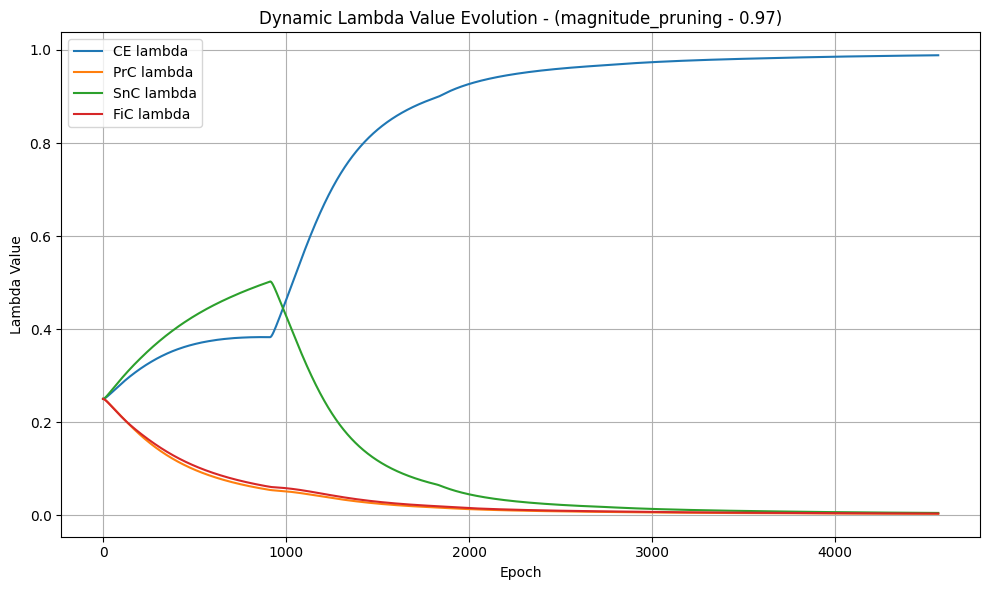

=== Lambda Statistics ===
CE lambda:
  Initial: 0.2500
  Final:   0.9886
  Change:  0.7386 (+295.46%)
  Mean:    0.7953
  StdDev:  0.2547

PrC lambda:
  Initial: 0.2500
  Final:   0.0030
  Change:  -0.2470 (-98.81%)
  Mean:    0.0349
  StdDev:  0.0521

SnC lambda:
  Initial: 0.2500
  Final:   0.0048
  Change:  -0.2452 (-98.06%)
  Mean:    0.1320
  StdDev:  0.1682

FiC lambda:
  Initial: 0.2500
  Final:   0.0035
  Change:  -0.2465 (-98.59%)
  Mean:    0.0377
  StdDev:  0.0532

[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b1.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b1.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation

Training epoch [1/50]: Avg Loss: 0.9709 | Avg Accuracy: 90.76 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.3076 | Avg Accuracy: 92.44 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2413 | Avg Accuracy: 92.68 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2194 | Avg Accuracy: 92.59 | Model Sparsity: 0.97



Training epoch [5/50]: Avg Loss: 0.1967 | Avg Accuracy: 93.16 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.1865 | Avg Accuracy: 93.65 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.1724 | Avg Accuracy: 93.02 | Model Sparsity: 0.97



Training epoch [8/50]: Avg Loss: 0.1675 | Avg Accuracy: 93.47 | Model Sparsity: 0.97



Training epoch [9/50]: Avg Loss: 0.1608 | Avg Accuracy: 93.92 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [10/50]: Avg Loss: 0.1528 | Avg Accuracy: 93.72 | Model Sparsity: 0.97



Training epoch [11/50]: Avg Loss: 0.1467 | Avg Accuracy: 93.85 | Model Sparsity: 0.97



Training epoch [12/50]: Avg Loss: 0.1389 | Avg Accuracy: 93.79 | Model Sparsity: 0.97



Training epoch [13/50]: Avg Loss: 0.1348 | Avg Accuracy: 93.79 | Model Sparsity: 0.97



Training epoch [14/50]: Avg Loss: 0.1289 | Avg Accuracy: 94.03 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [15/50]: Avg Loss: 0.1254 | Avg Accuracy: 93.96 | Model Sparsity: 0.97



Training epoch [16/50]: Avg Loss: 0.1238 | Avg Accuracy: 93.88 | Model Sparsity: 0.97



Training epoch [17/50]: Avg Loss: 0.1165 | Avg Accuracy: 93.76 | Model Sparsity: 0.97



Training epoch [18/50]: Avg Loss: 0.1116 | Avg Accuracy: 93.76 | Model Sparsity: 0.97



Training epoch [19/50]: Avg Loss: 0.1075 | Avg Accuracy: 93.90 | Model Sparsity: 0.97



Training epoch [20/50]: Avg Loss: 0.1052 | Avg Accuracy: 94.10 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [21/50]: Avg Loss: 0.1020 | Avg Accuracy: 94.21 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [22/50]: Avg Loss: 0.0974 | Avg Accuracy: 93.93 | Model Sparsity: 0.97



Training epoch [23/50]: Avg Loss: 0.0946 | Avg Accuracy: 94.20 | Model Sparsity: 0.97



Training epoch [24/50]: Avg Loss: 0.0955 | Avg Accuracy: 94.36 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [25/50]: Avg Loss: 0.0897 | Avg Accuracy: 93.96 | Model Sparsity: 0.97



Training epoch [26/50]: Avg Loss: 0.0859 | Avg Accuracy: 94.02 | Model Sparsity: 0.97



Training epoch [27/50]: Avg Loss: 0.0815 | Avg Accuracy: 93.89 | Model Sparsity: 0.97



Training epoch [28/50]: Avg Loss: 0.0800 | Avg Accuracy: 94.10 | Model Sparsity: 0.97



Training epoch [29/50]: Avg Loss: 0.0774 | Avg Accuracy: 94.11 | Model Sparsity: 0.97



Training epoch [30/50]: Avg Loss: 0.0732 | Avg Accuracy: 94.18 | Model Sparsity: 0.97



Training epoch [31/50]: Avg Loss: 0.0748 | Avg Accuracy: 94.02 | Model Sparsity: 0.97



Training epoch [32/50]: Avg Loss: 0.0667 | Avg Accuracy: 93.81 | Model Sparsity: 0.97



Training epoch [33/50]: Avg Loss: 0.0699 | Avg Accuracy: 94.13 | Model Sparsity: 0.97



Training epoch [34/50]: Avg Loss: 0.0657 | Avg Accuracy: 94.17 | Model Sparsity: 0.97



Training epoch [35/50]: Avg Loss: 0.0653 | Avg Accuracy: 93.95 | Model Sparsity: 0.97



Training epoch [36/50]: Avg Loss: 0.0642 | Avg Accuracy: 94.42 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [37/50]: Avg Loss: 0.0611 | Avg Accuracy: 94.22 | Model Sparsity: 0.97



Training epoch [38/50]: Avg Loss: 0.0598 | Avg Accuracy: 94.08 | Model Sparsity: 0.97



Training epoch [39/50]: Avg Loss: 0.0555 | Avg Accuracy: 94.29 | Model Sparsity: 0.97



Training epoch [40/50]: Avg Loss: 0.0555 | Avg Accuracy: 94.27 | Model Sparsity: 0.97



Training epoch [41/50]: Avg Loss: 0.0554 | Avg Accuracy: 93.79 | Model Sparsity: 0.97



Training epoch [42/50]: Avg Loss: 0.0486 | Avg Accuracy: 93.93 | Model Sparsity: 0.97



Training epoch [43/50]: Avg Loss: 0.0516 | Avg Accuracy: 94.28 | Model Sparsity: 0.97



Training epoch [44/50]: Avg Loss: 0.0501 | Avg Accuracy: 93.82 | Model Sparsity: 0.97



Training epoch [45/50]: Avg Loss: 0.0451 | Avg Accuracy: 94.04 | Model Sparsity: 0.97



Training epoch [46/50]: Avg Loss: 0.0465 | Avg Accuracy: 94.20 | Model Sparsity: 0.97



Training epoch [47/50]: Avg Loss: 0.0444 | Avg Accuracy: 93.76 | Model Sparsity: 0.97



Training epoch [48/50]: Avg Loss: 0.0449 | Avg Accuracy: 94.06 | Model Sparsity: 0.97



Training epoch [49/50]: Avg Loss: 0.0442 | Avg Accuracy: 94.13 | Model Sparsity: 0.97



Training epoch [50/50]: Avg Loss: 0.0422 | Avg Accuracy: 94.04 | Model Sparsity: 0.97

[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_b1_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.97



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.11%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9700 (97.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b1_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Object saved successfully to resnet50_cifar10_magnitude_pruning_0.97_lambda_history.pkl


True

In [5]:
# Initializing finetuned weights path
finetuned_weights = f"./research/{MODEL_NAME}/{MODEL_TASK}/{MODEL_NAME}_{MODEL_TASK}_baseline.pt"

bacp_training_args = BaCPTrainingArguments(
    model_name=MODEL_NAME,
    model_task=MODEL_TASK,
    batch_size=BATCH_SIZE_CNN,
    optimizer_type_and_lr=('sgd', 0.1),
    pruning_type='magnitude_pruning',
    target_sparsity=TARGET_SPARSITY_MID,
    sparsity_scheduler='cubic',
    finetuned_weights=finetuned_weights,
    learning_type='bacp_pruning_b1',
    db=False,
)
bacp_trainer = BaCPTrainer(bacp_training_args, lambdas=None)
if True:
    bacp_trainer.train()
    print_dynamic_lambdas_statistics(bacp_trainer)

bacp_trainer.generate_mask_from_model()
training_args = TrainingArguments(
    model_name=bacp_trainer.model_name,
    model_task=bacp_trainer.model_task,
    batch_size=bacp_trainer.batch_size,
    optimizer_type_and_lr=('adamw', 0.0001),
    pruner=bacp_trainer.get_pruner(),
    pruning_type=bacp_trainer.pruning_type,
    target_sparsity=bacp_trainer.target_sparsity,
    epochs=50,
    finetuned_weights=bacp_trainer.save_path,
    finetune=True,
    learning_type="bacp_b1_finetune",
    db=False,
)
trainer = Trainer(training_args)
if True:
    trainer.train()

metrics = trainer.evaluate()
print_statistics(metrics, trainer)

save_object(
    bacp_trainer.lambda_history, 
    f'{MODEL_NAME}_{MODEL_TASK}_{bacp_trainer.pruning_type}_{bacp_trainer.target_sparsity}_lambda_history.pkl'
    )

In [ ]:
# Initializing finetuned weights path
finetuned_weights = f"./research/{MODEL_NAME}/{MODEL_TASK}/{MODEL_NAME}_{MODEL_TASK}_baseline.pt"

bacp_training_args = BaCPTrainingArguments(
    model_name=MODEL_NAME,
    model_task=MODEL_TASK,
    batch_size=BATCH_SIZE_CNN,
    optimizer_type_and_lr=('sgd', 0.1),
    pruning_type='magnitude_pruning',
    target_sparsity=TARGET_SPARSITY_HIGH,
    sparsity_scheduler='cubic',
    finetuned_weights=finetuned_weights,
    learning_type='bacp_pruning_b1',
    db=False,
)
bacp_trainer = BaCPTrainer(bacp_training_args, lambdas=None)
if True:
    bacp_trainer.train()
    print_dynamic_lambdas_statistics(bacp_trainer)

bacp_trainer.generate_mask_from_model()
training_args = TrainingArguments(
    model_name=bacp_trainer.model_name,
    model_task=bacp_trainer.model_task,
    batch_size=bacp_trainer.batch_size,
    optimizer_type_and_lr=('adamw', 0.0001),
    pruner=bacp_trainer.get_pruner(),
    pruning_type=bacp_trainer.pruning_type,
    target_sparsity=bacp_trainer.target_sparsity,
    epochs=50,
    finetuned_weights=bacp_trainer.save_path,
    finetune=True,
    learning_type="bacp_b1_finetune",
    db=False,
)
trainer = Trainer(training_args)
if True:
    trainer.train()

metrics = trainer.evaluate()
print_statistics(metrics, trainer)

save_object(
    bacp_trainer.lambda_history, 
    f'{MODEL_NAME}_{MODEL_TASK}_{bacp_trainer.pruning_type}_{bacp_trainer.target_sparsity}_lambda_history.pkl'
    )

[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[TRAINER] No scheduler initialized
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] Pruning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Target sparsity: 0.99
[TRAINER] Sparsity scheduler: cubic
[TRAINER] Pruning epochs: 5
[TRAINER] Current sparsity: 0.0000
[TRAINER] Saving model to: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b1.pt
[LOGGER] Log file created at location: ./log_records/resnet50/cifar10/bacp_pruning_b1/magnitude_pruning/0.99/run_1.log


Training Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.483.



Epoch [1/5]: Avg Total Loss: 7.1183 | Avg PrC Loss: 3.3661 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3584 | Avg CE Loss: 0.3939 | Model Sparsity: 0.4831

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 5.6033 | Avg PrC Loss: 2.8168 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.5602 | Avg CE Loss: 0.2263 | Model Sparsity: 0.4831



Retraining Epoch [2/10]: Avg Total Loss: 4.6427 | Avg PrC Loss: 2.3677 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.0990 | Avg CE Loss: 0.1760 | Model Sparsity: 0.4831



Retraining Epoch [3/10]: Avg Total Loss: 3.9488 | Avg PrC Loss: 1.9999 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.7956 | Avg CE Loss: 0.1533 | Model Sparsity: 0.4831



Retraining Epoch [4/10]: Avg Total Loss: 3.3819 | Avg PrC Loss: 1.6992 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.5436 | Avg CE Loss: 0.1391 | Model Sparsity: 0.4831



Retraining Epoch [5/10]: Avg Total Loss: 2.9215 | Avg PrC Loss: 1.4568 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.3357 | Avg CE Loss: 0.1290 | Model Sparsity: 0.4831



Retraining Epoch [6/10]: Avg Total Loss: 2.5470 | Avg PrC Loss: 1.2622 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.1662 | Avg CE Loss: 0.1186 | Model Sparsity: 0.4831



Retraining Epoch [7/10]: Avg Total Loss: 2.2452 | Avg PrC Loss: 1.1052 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 1.0269 | Avg CE Loss: 0.1131 | Model Sparsity: 0.4831



Retraining Epoch [8/10]: Avg Total Loss: 2.0037 | Avg PrC Loss: 0.9776 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 0.9141 | Avg CE Loss: 0.1119 | Model Sparsity: 0.4831



Retraining Epoch [9/10]: Avg Total Loss: 1.7992 | Avg PrC Loss: 0.8725 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 0.8201 | Avg CE Loss: 0.1066 | Model Sparsity: 0.4831



Retraining Epoch [10/10]: Avg Total Loss: 1.6309 | Avg PrC Loss: 0.7854 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 0.7413 | Avg CE Loss: 0.1042 | Model Sparsity: 0.4831



Training Epoch [2/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.776.



Epoch [2/5]: Avg Total Loss: 6.5523 | Avg PrC Loss: 0.7478 | Avg SnC Loss: 4.9434 | Avg FiC Loss: 0.7030 | Avg CE Loss: 0.1581 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 5.6171 | Avg PrC Loss: 0.6995 | Avg SnC Loss: 4.0761 | Avg FiC Loss: 0.6590 | Avg CE Loss: 0.1825 | Model Sparsity: 0.7762



Retraining Epoch [2/10]: Avg Total Loss: 4.7163 | Avg PrC Loss: 0.6362 | Avg SnC Loss: 3.2858 | Avg FiC Loss: 0.6018 | Avg CE Loss: 0.1925 | Model Sparsity: 0.7762



Retraining Epoch [3/10]: Avg Total Loss: 3.9084 | Avg PrC Loss: 0.5642 | Avg SnC Loss: 2.6091 | Avg FiC Loss: 0.5356 | Avg CE Loss: 0.1995 | Model Sparsity: 0.7762



Retraining Epoch [4/10]: Avg Total Loss: 3.2695 | Avg PrC Loss: 0.4943 | Avg SnC Loss: 2.0823 | Avg FiC Loss: 0.4719 | Avg CE Loss: 0.2210 | Model Sparsity: 0.7762



Retraining Epoch [5/10]: Avg Total Loss: 2.7512 | Avg PrC Loss: 0.4320 | Avg SnC Loss: 1.6768 | Avg FiC Loss: 0.4133 | Avg CE Loss: 0.2290 | Model Sparsity: 0.7762



Retraining Epoch [6/10]: Avg Total Loss: 2.3522 | Avg PrC Loss: 0.3794 | Avg SnC Loss: 1.3750 | Avg FiC Loss: 0.3637 | Avg CE Loss: 0.2341 | Model Sparsity: 0.7762



Retraining Epoch [7/10]: Avg Total Loss: 2.0615 | Avg PrC Loss: 0.3357 | Avg SnC Loss: 1.1523 | Avg FiC Loss: 0.3231 | Avg CE Loss: 0.2503 | Model Sparsity: 0.7762



Retraining Epoch [8/10]: Avg Total Loss: 1.8046 | Avg PrC Loss: 0.2997 | Avg SnC Loss: 0.9760 | Avg FiC Loss: 0.2884 | Avg CE Loss: 0.2406 | Model Sparsity: 0.7762



Retraining Epoch [9/10]: Avg Total Loss: 1.6255 | Avg PrC Loss: 0.2699 | Avg SnC Loss: 0.8433 | Avg FiC Loss: 0.2603 | Avg CE Loss: 0.2520 | Model Sparsity: 0.7762



Retraining Epoch [10/10]: Avg Total Loss: 1.4674 | Avg PrC Loss: 0.2449 | Avg SnC Loss: 0.7375 | Avg FiC Loss: 0.2365 | Avg CE Loss: 0.2485 | Model Sparsity: 0.7762



Training Epoch [3/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.927.



Epoch [3/5]: Avg Total Loss: 1.9516 | Avg PrC Loss: 0.2229 | Avg SnC Loss: 1.2534 | Avg FiC Loss: 0.2143 | Avg CE Loss: 0.2611 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 1.6696 | Avg PrC Loss: 0.1980 | Avg SnC Loss: 1.0365 | Avg FiC Loss: 0.1905 | Avg CE Loss: 0.2446 | Model Sparsity: 0.9266



Retraining Epoch [2/10]: Avg Total Loss: 1.4709 | Avg PrC Loss: 0.1783 | Avg SnC Loss: 0.8791 | Avg FiC Loss: 0.1717 | Avg CE Loss: 0.2418 | Model Sparsity: 0.9266



Retraining Epoch [3/10]: Avg Total Loss: 1.3145 | Avg PrC Loss: 0.1625 | Avg SnC Loss: 0.7600 | Avg FiC Loss: 0.1565 | Avg CE Loss: 0.2356 | Model Sparsity: 0.9266



Retraining Epoch [4/10]: Avg Total Loss: 1.2082 | Avg PrC Loss: 0.1493 | Avg SnC Loss: 0.6695 | Avg FiC Loss: 0.1439 | Avg CE Loss: 0.2455 | Model Sparsity: 0.9266



Retraining Epoch [5/10]: Avg Total Loss: 1.1104 | Avg PrC Loss: 0.1382 | Avg SnC Loss: 0.5954 | Avg FiC Loss: 0.1333 | Avg CE Loss: 0.2435 | Model Sparsity: 0.9266



Retraining Epoch [6/10]: Avg Total Loss: 1.0267 | Avg PrC Loss: 0.1287 | Avg SnC Loss: 0.5362 | Avg FiC Loss: 0.1243 | Avg CE Loss: 0.2374 | Model Sparsity: 0.9266



Retraining Epoch [7/10]: Avg Total Loss: 0.9647 | Avg PrC Loss: 0.1206 | Avg SnC Loss: 0.4870 | Avg FiC Loss: 0.1165 | Avg CE Loss: 0.2406 | Model Sparsity: 0.9266



Retraining epoch [8/10]:  18%|█▊        | 15/83 [00:04<00:16,  4.09it/s, Loss=0.922, PrC Loss=0.116, SnC Loss=0.459, FiC Loss=0.112, CE Loss=0.235]